# TP Explainable AI at SET

Together we will discover two main approaches to explanaible artificial intelligence (xAI)

## Post-hoc explanation methods

We will use the [Captum](https://captum.ai/) library. This tutorial is adapted from the CAPTUM [original tutorial on CIFAR10](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret). 

### Gradient-based approaches

[Integrated Gradients](https://arxiv.org/abs/1703.01365)

### Perturbation-based approaches

[LIME](https://christophm.github.io/interpretable-ml-book/lime.html)

## By-design explanation methods
We will study the [ProtoTree](https://arxiv.org/abs/2012.02046) architecture. We will use the [CaBRNet](https://git.frama-c.com/pub/cabrnet) library, developped at CEA, which reimplements ProtoTree, among other interpretable-by-design architectures.

## Preliminaries

### Environment setup

Install all dependencies in a dedicated virtual environment. This may take some time.
Outside of the jupyter, you can use the following command:

`virtualenv -p /usr/bin/python3 ./venv/setixaitp ; source ./venv/setixaitp/bin/activate; python3 -m pip install -r requirements.txt`

Then, to access to the material by typing `jupyter notebook TP_SETI.ipynb`

In [18]:
 !virtualenv -p /usr/bin/python3 ./venv/setixaitp ; source ./venv/setixaitp/bin/activate; python3 -m pip install -r requirements.txt 

created virtual environment CPython3.10.12.final.0-64 in 166ms
  creator CPython3Posix(dest=/home/julien/Enseignement/seti_master/xAI_by_design/code/venv/setixaitp, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/julien/.local/share/virtualenv)
    added seed packages: Babel==2.14.0, Jinja2==3.1.3, MarkupSafe==2.1.4, PyYAML==6.0.1, QtPy==2.4.1, Send2Trash==1.8.2, anyio==4.2.0, argon2_cffi==23.1.0, argon2_cffi_bindings==21.2.0, arrow==1.3.0, asttokens==2.4.1, async_lru==2.0.4, attrs==23.2.0, beautifulsoup4==4.12.3, bleach==6.1.0, cabrnet==0.1a0, captum==0.7.0, certifi==2023.11.17, cffi==1.16.0, charset_normalizer==3.3.2, comm==0.2.1, contourpy==1.2.0, cycler==0.12.1, debugpy==1.8.0, decorator==5.1.1, defusedxml==0.7.1, exceptiongroup==1.2.0, executing==2.0.1, fastjsonschema==2.19.1, filelock==3.13.1, fonttools==4.47.2, fqdn==1.5.1, fsspec==2023.12.2, idna==3.6, ipykernel==6.29.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import captum
from captum.attr import visualization as viz

import torchvision
import torchvision.transforms.v2 as transforms

import cabrnet 
from zenodo_get import zenodo_get

We will use for this session a reduced image set of the dataset [CUB200](http://www.vision.caltech.edu/datasets/cub_200_2011/). This is to avoid unecessary training time and inference.

In [20]:
transform = transforms.Compose(
    [transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),
     transforms.Resize((224,224),antialias=True),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])
tinyCub = torchvision.datasets.ImageFolder(root="./data/cub_train_tiny", transform=transform)

 We will also load a pretrained model on Cub200 (a ResNet 50) for Post-Hoc explanations. For Explanations by-design, we will load the model using the Cabernet library loading utilities

In [21]:
modelPostHoc = torch.load('./models/r50_CUB200_i448.pth',map_location='cpu')
# Download CaBRNet pretrained model on CUB200
zenodo_get(["-o","./models/cabrnet/","-r","10556430"])

Title: CaBRNet model trained with the ProtoTree architecture on the CUB200 dataset
Keywords: 
Publication date: 2024-01-23
DOI: 10.5281/zenodo.10556430
Total size: 189.3 MB

Link: https://zenodo.org/record/10556430/files/cabrnet_cub200.zip   size: 189.3 MB
cabrnet_cub200.zip is already downloaded correctly.
All files have been downloaded.


### Sanity checks

We will begin by loading some images from the dataset, pass them through the model and see if the predictions are correct. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


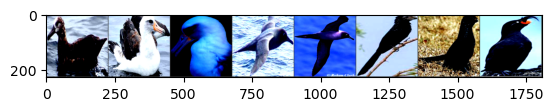

GroundTruth:  Black_footed_Albatross Laysan_Albatross Laysan_Albatross Sooty_Albatross
Predicted:  Black_footed_Albatross Forsters_Tern Horned_Puffin Green_tailed_Towhee


In [17]:
def imshow(img):
    img = img / 2 + 0.2     # hackish unnormalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

loader = torch.utils.data.DataLoader(tinyCub, batch_size=8)
classes = list(map(lambda x: x.split(".")[1], tinyCub.classes))
[imgs, targets] = next(iter(loader))
res = modelPostHoc(imgs)
imshow(torchvision.utils.make_grid(imgs))
print('GroundTruth: ', ' '.join('%5s' % classes[targets[j]] for j in range(4)))
_, predicted = torch.max(res, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

## Post Hoc explanation methods

### Saliency maps

We will first apply the simplest attribution method: gradient. We will propagate gradient for one image, and project it back.

Original Image
Predicted: tensor(0)  Probability: 0.9735740423202515


/home/julien/micromamba/envs/setixai/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


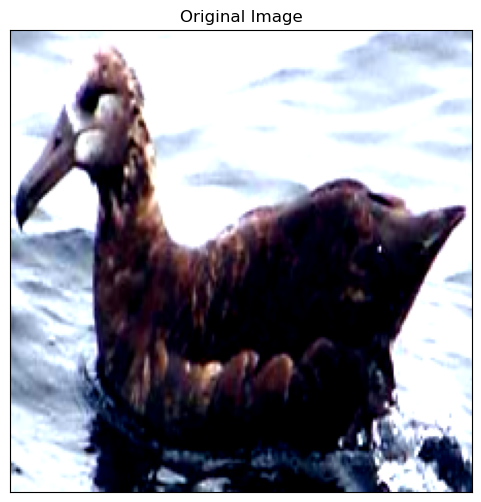

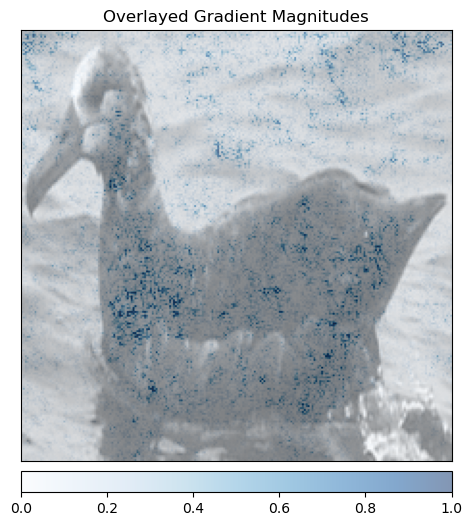

In [7]:
input = imgs[0].unsqueeze(0)
target = targets[0]
input.require_grads = True
saliency = captum.attr.Saliency(modelPostHoc)
grads = saliency.attribute(inputs=input, target=target, abs=False)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', predicted[0], 
      ' Probability:', torch.max(torch.nn.functional.softmax(res, 1)).item())

original_image = np.transpose((imgs[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

We note that the gradient is mostly ditributed on the neck, the tail, but also on the corder of the image.

* This may translate what the neural network actually use to take its decision, but it goes against our intuition on how we are recognizing ducks
* Part of the backprojection to the input space is hidden under the _viz_ python module

### Integrated gradients

Contrary to saliency maps, Integrated Gradients compute a linear approximation of the gradient between an image and a target class. It answers to the question "what should change in my image to change class"? 

Approximation delta:  tensor([0.1188], dtype=torch.float64)


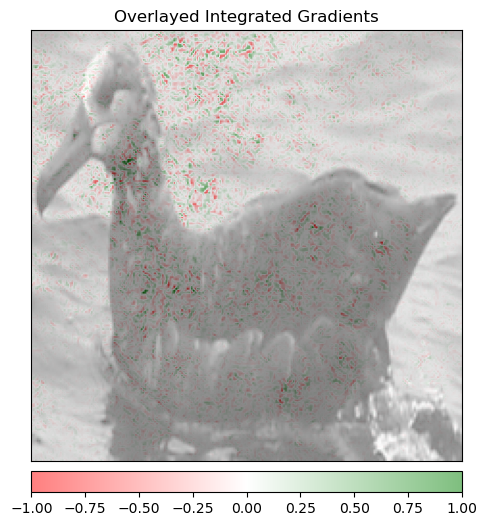

In [13]:
ig = captum.attr.IntegratedGradients(modelPostHoc)
attributions, delta = ig.attribute(inputs=input,  baselines=None, target=2, return_convergence_delta=True)
attributions = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))
_ = viz.visualize_image_attr(attributions, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

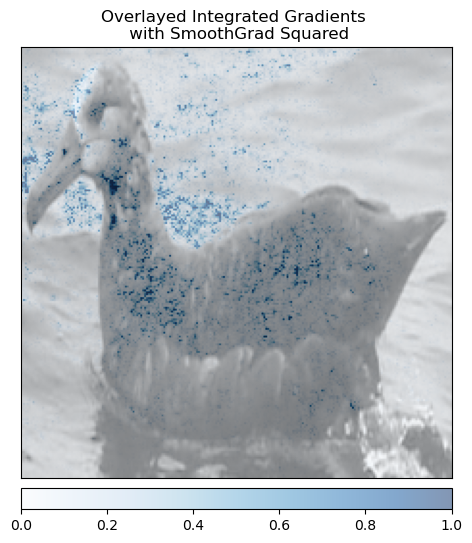

In [11]:
ig = captum.attr.IntegratedGradients(modelPostHoc)
nt = captum.attr.NoiseTunnel(ig)
attributions_smoothgrad = nt.attribute(inputs=input, baselines=input * 0, target=1, nt_type='smoothgrad_sq', nt_samples=4, stdevs=0.2)
attributions_smoothgrad = np.transpose(attributions_smoothgrad.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
_ = viz.visualize_image_attr(attributions_smoothgrad, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

We note that integrated gradients with smoothgrads provide much more focused variations.

## Explainable by design

We will now look at explainable by design models

### ProtoTree